In [ ]:
import matplotlib.pyplot as plt

from bofire.data_models.constraints.api import LinearEqualityConstraint
from bofire.data_models.domain.api import Domain
from bofire.data_models.features.api import ContinuousInput, ContinuousOutput
from bofire.strategies.doe.design import find_local_max_ipopt
from bofire.strategies.enum import OptimalityCriterionEnum

/opt/homebrew/Caskroom/miniforge/base/envs/bofire/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Designs for different optimality criteria


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



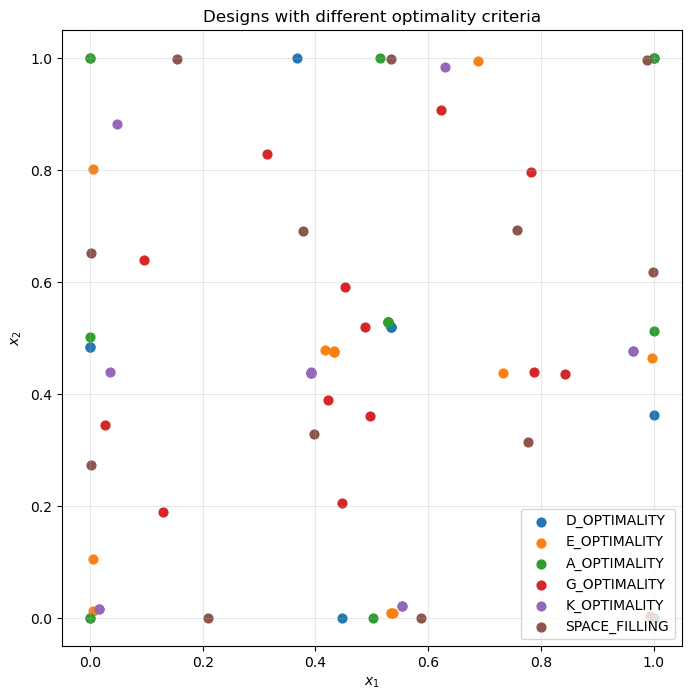

In [ ]:
# Optimal designs for a quadratic model on the unit square
domain = Domain(
    inputs=[ContinuousInput(key=f"x{i+1}", bounds=(0, 1)) for i in range(2)],
    outputs=[ContinuousOutput(key="y")],
)
model_type = "fully-quadratic"
n_experiments = 13

designs = {}
for obj in OptimalityCriterionEnum:
    designs[obj.value] = find_local_max_ipopt(
        domain,
        model_type=model_type,
        n_experiments=n_experiments,
        objective=obj,
        ipopt_options={"maxiter": 300},
    ).to_numpy()

fig = plt.figure(figsize=((8, 8)))
ax = fig.add_subplot(111)
ax.set_title("Designs with different optimality criteria")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
for obj, X in designs.items():
    ax.scatter(X[:, 0], X[:, 1], s=40, label=obj)
ax.grid(alpha=0.3)
ax.legend();

### Space filling design

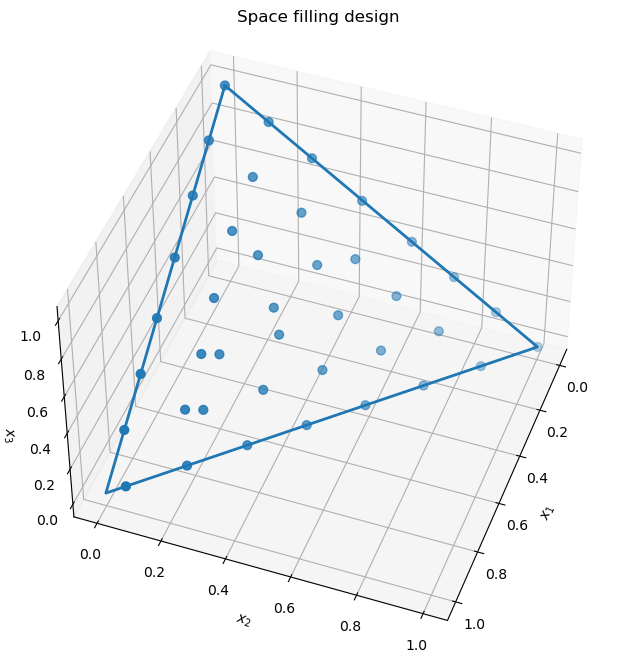

In [ ]:
# Space filling design on the unit 2-simplex
domain = Domain(
    inputs=[ContinuousInput(key=f"x{i+1}", bounds=(0, 1)) for i in range(3)],
    outputs=[ContinuousOutput(key="y")],
    constraints=[
        LinearEqualityConstraint(
            features=["x1", "x2", "x3"], coefficients=[1, 1, 1], rhs=1
        )
    ],
)

X = find_local_max_ipopt(
    domain,
    n_experiments=40,
    model_type="linear",  # the model type does not matter for space filling designs
    objective=OptimalityCriterionEnum.SPACE_FILLING,
    ipopt_options={"maxiter": 500},
).to_numpy()


fig = plt.figure(figsize=((10, 8)))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(45, 20)
ax.set_title("Space filling design")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")

# plot feasible polytope
ax.plot(xs=[0, 0, 1, 0], ys=[0, 1, 0, 0], zs=[1, 0, 0, 1], linewidth=2)

# plot design points
ax.scatter(xs=X[:, 0], ys=X[:, 1], zs=X[:, 2], s=40)